In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

np.random.seed(1)

## Introduction

This jupyter notebook provides an overview of our time-consistent PINN implemenation for a simple system of ODEs of size two. The code is structured as follows:

1) An MLP class to define an MLP of arbitrary layer size with Tanh activation. In the tcPINN implementation, the inputs of the MLP will correspond to the time and the initial state (t, $y_0$).

2) A TcPINN class implementing the time-consistent physics-informed neural network. The input of the network are the time and the initial state (t, $y_0$) of the ODE solution. The output is $y_0 + t \cdot N(t, y_0)$, where $N$ the user-defined MLP from 1), and approximates the solution of the ODE at time $t$ with initial state $y_0$. This class includes the definition of the standard PINN loss, and the semgigroup- and smoothness-loss functions - the two key contributions of our project. We also implement a data loss, which is used when solving inverse problems.

3) An example of how to generate the training data points and train a tcPINN.

4) A visualization of the predicted time-consistent ODE solution beyond the maximum time in the training dataset.

5) An evaluation of the tcPINN measuring the average Euclidean distance of points on predicted trajectories to the (a priori known) true solutions.

We consider the linear ODE

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}(t) = \begin{pmatrix} -y_2 \\ y_1 \end{pmatrix} (t).
\end{align*}

For a given initial state $y_0 = (y_0^1, y_0^2) \in \mathbb{R}^2$, the solution $(y(t))_{t\geq0}$ flows in counter clockwise circles and is given by

\begin{align*}
    y(t) = \begin{pmatrix} y_0^1 \cos(t) - y_0^2 \sin(t) \\ y_0^2 \cos(t) + y_0^1 \sin(t) \end{pmatrix}.
\end{align*}

In [2]:
def solution_circle_ode(t, y0):
    
    y1t = y0[0] * np.cos(t) - y0[1] * np.sin(t)
    y2t = y0[1] * np.cos(t) + y0[0] * np.sin(t)

    return np.array([y1t, y2t])

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")

In [4]:
class MLP(torch.nn.Module):
    """
    Define an multilayer perceptron (MLP) with arbitrary layers and Tanh activation. 
    In the time-consistent physics informed neural network (tcPINN) implementation,
    the inputs of the MLP will correspond to the time and the initial state (t, 𝑦0).
    """    
    def __init__(self, layers):
        """
        Build the MLP.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer.
            Entry i of 'list' specifies the number of neurons in layer i.
        """
        super().__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        
        for i in range(self.depth - 1):    
            layer_list.append(
                (f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append((f"activation_{i}", self.activation()))
            
        layer_list.append(
            (f"layer_{self.depth - 1}", torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        """
        Apply the neural network to the input 'x'. In the tcPINN implementation,
        'x' = (t, y0), where t is the time and y0 is the initial state.
        """
        return self.layers(x)

In [5]:
class TcPINN:
    """
    A blueprint implementation of a tcPINN. The only method specific to the considered ODE is '_loss_pinn',
    which implements the ODE-induced loss term.
    """
    def __init__(self, layers, T, X_pinn=None, X_semigroup=None, X_smooth=None, X_data=None, data=None):
        """
        Initialize the MLP and the training data. It is possible to use a subset of the 
        four loss functions {standard PINN loss, semigroup loss, smoothness loss, data loss} by
        only providing some of the training data.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer of the MLP.
            Entry i of 'list' specifies the number of neurons in layer i.
        
        T: float
            The supremum of all times in the training data. When predicting the solution of
            the ODE after time T, the trajectory has to be stitched together.
        
        X_pinn: np.ndarray
            The training data for the standard PINN loss. The first column of 'X_pinn'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_semigroup: np.ndarray
            The training data for the semigroup loss. The first column of 'X_semigroup'
            corresponds to the length of the first time step, the second to the length of the
            second time step, and the other columns correspond to the intial values.
        
        X_smooth: np.ndarray
            The training data for the smoothness loss. The first column of 'X_smooth'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_data: np.ndarray
            The training data for the data loss. The first column of 'X_data'
            corresponds to the times, the other columns correspond to the intial values.
        
        data: np.ndarray
            The measured/true values of the ODE for the times and initial values given by
            'X_data'.
        """
        self.mlp = MLP(layers).to(device)
        self.ode_dimension = layers[-1]
        
        self.optimizer = torch.optim.LBFGS(
            self.mlp.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=10, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )
        self.iter = 0
        
        self.T = torch.tensor(T).float().to(device)
        self._init_training_data(X_pinn, X_semigroup, X_smooth, X_data, data)
    
    
    def _init_training_data(self, X_pinn, X_semigroup, X_smooth, X_data, data):
        
        if X_pinn is not None:
            self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
            self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
            self.use_standard = True
        
        else:
            self.use_standard = False
        
        if X_semigroup is not None:
            self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
            self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
            self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
            self.use_semigroup = True
        
        else:
            self.use_semigroup = False
        
        if X_smooth is not None:
            self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
            self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
            self.use_smooth = True
        
        else:
            self.use_smooth = False
        
        if X_data is not None:
            if data is None:
                raise ValueError("The true/measured solution for the 'X_data' points has to be provided.")
            self.t_data = torch.tensor(X_data[:, :1], requires_grad=True).float().to(device)
            self.y_data = torch.tensor(X_data[:, 1:], requires_grad=True).float().to(device)
            self.data = torch.tensor(data, requires_grad=True).float().to(device)
            self.use_data = True
        
        else:
            self.use_data = False
    
    
    def net_y(self, t, y0):
        """
        Let N(t, y0) denote the value of the MLP at time t for initial value y0.
        Let M(t, y0) denote the value of the tcPINN at time t for initial value y0.
        
        We set M(t, y0) = y0 + t * N(t, y0) to guarantee continuity of the trajectory
        when stitching together solutions for large times.
        """
        y = y0 + t * self.mlp(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivatives of the neural network
        with respect to time.
        
        Output:
        -------
        derivatives: list
            The i-th entry is the time derivative of the i-th output component of the neural network
            evaluated at all inputs (t, y0). Each input corresponds to one row in each tensor.
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output component
        vectors = [torch.zeros_like(y) for _ in range(self.ode_dimension)]
        
        for i, vec in enumerate(vectors):
            vec[:,i] = 1.
        
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def _loss_pinn(self):
        """
        The ODE-specific standard PINN loss.
        """
        y = self.net_y(self.t_pinn, self.y_pinn)
        deriv = self.net_derivative(self.t_pinn, self.y_pinn)
        
        loss1 = torch.mean((deriv[0] + y[:,1:2]) ** 2)
        loss2 = torch.mean((deriv[1] - y[:,0:1]) ** 2)
        loss = loss1 + loss2
        
        return loss
    
    
    def _loss_semigroup(self):
        """
        The general semigroup loss.
        """
        y_no_restart = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_restart = self.net_y(self.t_semigroup, y_s)
        loss = self.ode_dimension * torch.mean((y_no_restart - y_restart) ** 2)
        
        return loss
    
    
    def _loss_smooth(self):
        """
        The general smoothness loss.
        """
        deriv_below = self.net_derivative(self.t_smooth, self.y_smooth)
        y = self.net_y(self.t_smooth, self.y_smooth)
        deriv_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y)
        
        loss = .0
        
        for d1, d2 in zip(deriv_below, deriv_above):
            loss += torch.mean((d1 - d2) ** 2)
        
        return loss
    
    
    def _loss_data(self):
        """
        The general data loss.
        """
        y = self.net_y(self.t_data, self.y_data)
        loss = self.ode_dimension * torch.mean((y - self.data) ** 2)
        
        return loss
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        loss = .0
        
        if self.use_standard:
            loss_pinn = self._loss_pinn()
            loss += loss_pinn
        
        if self.use_semigroup:
            loss_semigroup = self._loss_semigroup()
            loss += loss_semigroup
        
        if self.use_smooth:
            loss_smooth = self._loss_smooth()
            loss += loss_smooth
        
        if self.use_data:
            loss_data = self._loss_data()
            loss += loss_data
        
        loss.backward()       
        self.iter += 1
        
        if self.iter % 100 == 0:
            info = f"iteration {self.iter}, loss: {loss.item():.4f}"
            
            if self.use_standard:
                info += f", PINN loss: {loss_pinn.item():.4f}"
            
            if self.use_semigroup:
                info += f", semigroup loss: {loss_semigroup.item():.4f}"
            
            if self.use_smooth:
                info += f", smoothness loss: {loss_smooth.item():.4f}"
            
            if self.use_data:
                info += f", data loss: {loss_data.item():.4f}"
            
            print(info)
        
        return loss    
    
    
    def train(self):
        """
        Train the MLP parameters with the LBFGS optimizer.
        """
        self.mlp.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        """
        Evaluate the tcPINN at times 't' for initial values 'y0'.
        Each row (!) in 't' and 'y0' is one time point and intial value, respectively.
        """
        t = torch.tensor(t).float().to(device)
        y0 = torch.tensor(y0).float().to(device)
        
        self.mlp.eval()
        prediction = self.net_y(t, y0)
        prediction = prediction.detach().cpu().numpy()
        
        return prediction
    
    
    def predict_standard(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is not (!) applied multiple times to stitch together trajectories.
        The predicted trajectory will therefore most likely be incorrect for all times 
        t > self.T.
        """        
        times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
        times = times[:, np.newaxis]
        y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
        
        trajectory = self.predict(times, y0s)
        
        return trajectory
    
    
    def predict_tc(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is applied multiple times to stitch together trajectories.
        """
        times = np.arange(0, self.T + delta_t, delta_t)[1:]
        times = times[:, np.newaxis]
        n_resets = int(np.ceil(max_t / self.T))
        
        trajectory = np.array([y0])
        
        for _ in range(n_resets):
            
            y0 = trajectory[-1]
            y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
            segment =  self.predict(times, y0s)
            trajectory = np.vstack([trajectory, segment])
        
        return trajectory

### Training Example

In [6]:
def sample_circle_2d(n_samples, radius):
    """
    Sample 'n_samples' points from the circle with center (0,0) and radius 'radius'.
    """
    length = np.sqrt(np.random.uniform(0, radius ** 2, size=n_samples))
    angle = np.pi * np.random.uniform(0, 2, size=n_samples)

    y0 = length * np.cos(angle)
    y1 = length * np.sin(angle)
    points = np.stack([y0, y1], axis=0).T
    
    return points


def sample_triangle_2d(n_samples, side_length):
    """
    Sample 'n_samples' points from the triangle with corners 
    (0,0), ('side_length', 0) and (0, 'side_length').
    """
    r1 = np.random.uniform(0, 1, size=n_samples)
    r2 = np.random.uniform(0, 1, size=n_samples)
    
    y0 = np.sqrt(r1) * (1 - r2)
    y1 = r2 * np.sqrt(r1)
    
    y0 *= side_length
    y1 *= side_length
    points = np.stack([y0, y1], axis=0).T
    
    return points

In [7]:
layers = [3, 32, 32, 32, 32, 32, 2]

T = 1
radius = 3

# training samples
n_pinn = 100
t_pinn = np.random.uniform(0, T, size=(n_pinn, 1))
y_pinn = sample_circle_2d(n_pinn, radius)
X_pinn = np.hstack([t_pinn, y_pinn])

n_semigroup = 100
st_semigroup = sample_triangle_2d(n_semigroup, T)
y_semigroup = sample_circle_2d(n_semigroup, radius)
X_semigroup = np.hstack([st_semigroup, y_semigroup])

n_smooth = 100
t_smooth = np.random.uniform(0, T, size=(n_smooth, 1))
y_smooth = sample_circle_2d(n_smooth, radius)
X_smooth = np.hstack([t_smooth, y_smooth])

n_data = 100
t_data = np.random.uniform(0, T, size=(n_data, 1))
y_data = sample_circle_2d(n_data, radius)
X_data = np.hstack([t_data, y_data])
data = np.array([
    solution_circle_ode(t, y0) for t, y0 in zip(t_data.flatten(), y_data)
])
# don't use any data during training
X_data, data = None, None

In [8]:
model = TcPINN(
    layers=layers, T=T, 
    X_pinn=X_pinn, X_semigroup=X_semigroup, 
    X_smooth=X_smooth, X_data=X_data, data=data
)

In [9]:
%%time
               
model.train()

iteration 100, loss: 0.0112, PINN loss: 0.0061, semigroup loss: 0.0002, smoothness loss: 0.0049
iteration 200, loss: 0.0022, PINN loss: 0.0013, semigroup loss: 0.0000, smoothness loss: 0.0008
iteration 300, loss: 0.0009, PINN loss: 0.0006, semigroup loss: 0.0000, smoothness loss: 0.0003
iteration 400, loss: 0.0004, PINN loss: 0.0002, semigroup loss: 0.0000, smoothness loss: 0.0002
iteration 500, loss: 0.0003, PINN loss: 0.0001, semigroup loss: 0.0000, smoothness loss: 0.0001
iteration 600, loss: 0.0002, PINN loss: 0.0001, semigroup loss: 0.0000, smoothness loss: 0.0001
iteration 700, loss: 0.0001, PINN loss: 0.0001, semigroup loss: 0.0000, smoothness loss: 0.0000
iteration 800, loss: 0.0001, PINN loss: 0.0000, semigroup loss: 0.0000, smoothness loss: 0.0000
iteration 900, loss: 0.0001, PINN loss: 0.0000, semigroup loss: 0.0000, smoothness loss: 0.0000
iteration 1000, loss: 0.0001, PINN loss: 0.0000, semigroup loss: 0.0000, smoothness loss: 0.0000
iteration 1100, loss: 0.0001, PINN loss

## Predict and Plot a Trajectory

In [10]:
# Note that max_t is equal to 1 during training
y0 = np.array([1., 0.])
max_t_pred = 10.
delta_t = 0.1
times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)

validation_standard = model.predict_standard(max_t_pred, delta_t, y0)
validation_tc = model.predict_tc(max_t_pred, delta_t, y0)

true_solution = np.array([
    solution_circle_ode(t, y0) 
    for t in times
])

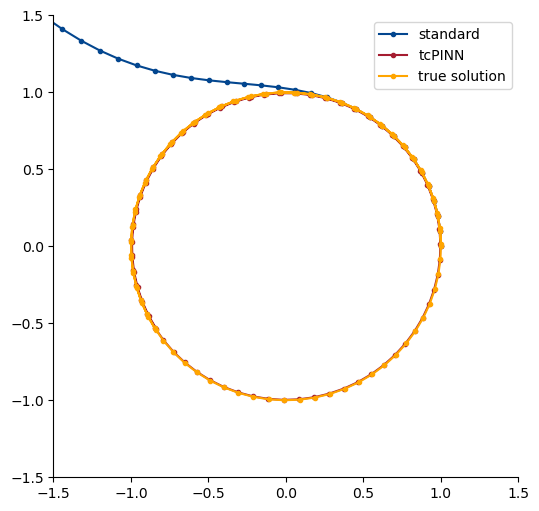

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.spines[['top', 'right']].set_visible(False)

radius = np.max(np.abs(y0)) + .5
ax.set_xlim([-radius, radius])
ax.set_ylim([-radius, radius])    

ax.plot(validation_standard[:,0], validation_standard[:,1], '.-', label="standard", color="#03468F")
ax.plot(validation_tc[:,0], validation_tc[:,1], '.-', label="tcPINN", color="#A51C30")
ax.plot(true_solution[:,0], true_solution[:,1], '.-', label="true solution", color="orange")

plt.legend()
plt.show()

## Evaluate the tcPINN

In [12]:
def evaluate(model, n_evaluate, max_t, delta_t, radius):
    
    times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
    n_timepoints = len(times)
    
    errors_standard = np.empty((n_evaluate, n_timepoints), dtype=float)
    errors_tc = np.empty((n_evaluate, n_timepoints), dtype=float)
    
    y0s = sample_circle_2d(n_evaluate, radius)
    
    for i, y0 in enumerate(y0s):
        
        solution_true = np.array([
            solution_circle_ode(t, y0)
            for t in times
        ])
        
        solution_standard = model.predict_standard(max_t, delta_t, y0)
        errors_standard[i] = np.sqrt(np.sum((solution_standard - solution_true) ** 2, axis=1))
        
        solution_tc = model.predict_tc(max_t, delta_t, y0)
        errors_tc[i] = np.sqrt(np.sum((solution_tc - solution_true) ** 2, axis=1))
    
    return errors_standard, errors_tc

In [13]:
n_evaluate = 1000
max_t = 2.
delta_t = .1
evaluation_times = np.linspace(0, max_t, int(max_t / delta_t) + 1)

errors_standard, errors_tc = evaluate(model, n_evaluate, max_t, delta_t, radius)

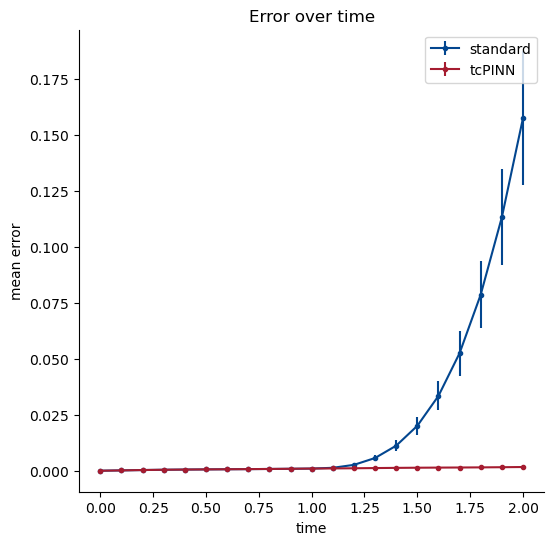

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.spines[['top', 'right']].set_visible(False)

ax.errorbar(
    evaluation_times, np.mean(errors_standard, axis=0), np.std(errors_standard, axis=0),
    marker=".", label="standard", color="#03468F"
)
ax.errorbar(
    evaluation_times, np.mean(errors_tc, axis=0), np.std(errors_tc, axis=0),
    marker=".", label="tcPINN", color="#A51C30"
)
ax.set(xlabel="time", ylabel="mean error", title="Error over time")

plt.legend()
plt.show()